In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load all 5 datasets
files = [
    "api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv",
    "api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv",
    "api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv",
    "api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv",
    "api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv",
]
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 1. State Standardization Dictionary
state_mapping = {
    "West  Bengal": "West Bengal",
    "West Bangal": "West Bengal",
    "Westbengal": "West Bengal",
    "WEST BENGAL": "West Bengal",
    "WESTBENGAL": "West Bengal",
    "West bengal": "West Bengal",
    "west Bengal": "West Bengal",
    "West Bengli": "West Bengal",
    "Orissa": "Odisha",
    "ODISHA": "Odisha",
    "odisha": "Odisha",
    "Pondicherry": "Puducherry",
    "Jammu & Kashmir": "Jammu and Kashmir",
    "Uttaranchal": "Uttarakhand",
    "Chhatisgarh": "Chhattisgarh",
    "andhra pradesh": "Andhra Pradesh",
    "Nagpur": "Maharashtra",
    "Jaipur": "Rajasthan",
    "Darbhanga": "Bihar",
    "BALANAGAR": "Telangana",
    "Madanapalle": "Andhra Pradesh",
    "Puttenahalli": "Karnataka",
    "Raja Annamalai Puram": "Tamil Nadu",
    "Dadra & Nagar Haveli": "Dadra and Nagar Haveli and Daman and Diu",
    "Dadra and Nagar Haveli": "Dadra and Nagar Haveli and Daman and Diu",
    "Daman & Diu": "Dadra and Nagar Haveli and Daman and Diu",
    "Daman and Diu": "Dadra and Nagar Haveli and Daman and Diu",
}

# 2. Apply Cleaning
df["state"] = df["state"].astype(str).str.strip()
df = df[df["state"] != "100000"]  # Remove numeric noise
df["state"] = df["state"].replace(state_mapping)


# 3. District Cleaning (Regex to remove special characters)
def clean_dist(text):
    text = re.sub(r"[*?]", "", str(text)).strip()
    return " ".join(text.split()).title()


df["district"] = df["district"].apply(clean_dist)

# 4. Feature Engineering
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df["month"] = df["date"].dt.to_period("M").astype(str)
df["quarter"] = df["date"].dt.to_period("Q").astype(str)
df["total_enrolments"] = df["demo_age_5_17"] + df["demo_age_17_"]

# Final Aggregated Dataset
df_clean = df.groupby(
    ["date", "month", "quarter", "state", "district", "pincode"], as_index=False
)[["demo_age_5_17", "demo_age_17_", "total_enrolments"]].sum()
print("Data Cleaning Complete. Total Records: ", len(df_clean))


Data Cleaning Complete. Total Records:  1585827


Step 2: Quarterly Enrolment Trends (Top 5 States)
This visualization identifies the "Heavy Lifters" and the massive surge in Q3.

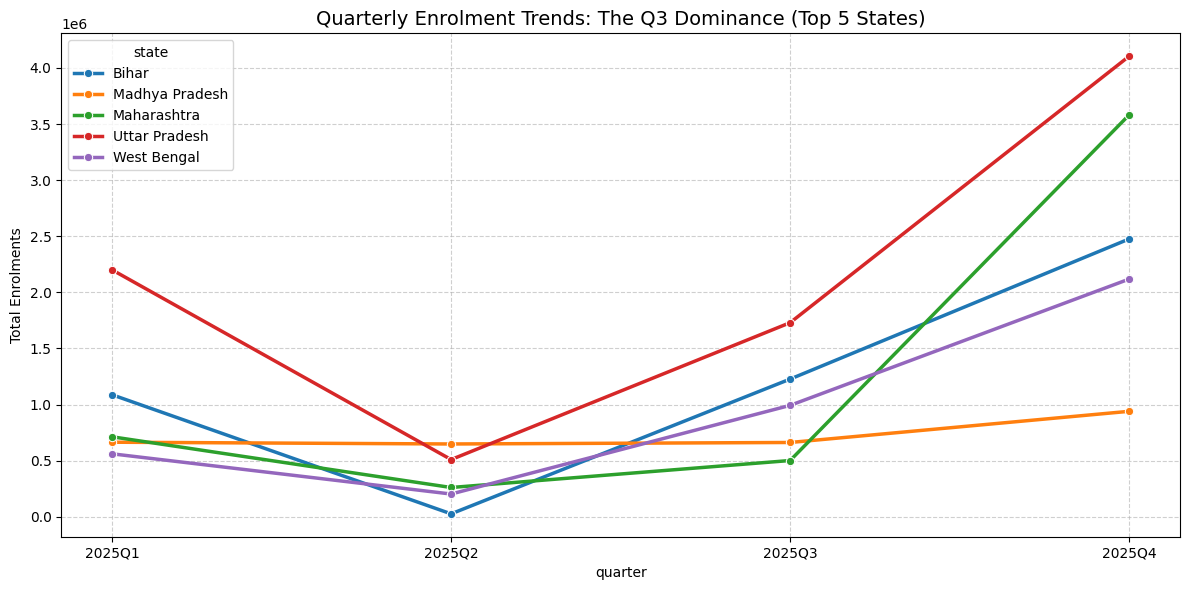

In [3]:
# Aggregate by Quarter and State
q_df = df_clean.groupby(["quarter", "state"], as_index=False)["total_enrolments"].sum()

# Identify top 5 states by total volume
top_5_states = q_df.groupby("state")["total_enrolments"].sum().nlargest(5).index

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=q_df[q_df["state"].isin(top_5_states)],
    x="quarter",
    y="total_enrolments",
    hue="state",
    marker="o",
    linewidth=2.5,
)

plt.title("Quarterly Enrolment Trends: The Q3 Dominance (Top 5 States)", fontsize=14)
plt.ylabel("Total Enrolments")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Step 3: Quarterly Growth Heatmap (%)

This identifies "Efficiency Pockets" by measuring momentum instead of just volum

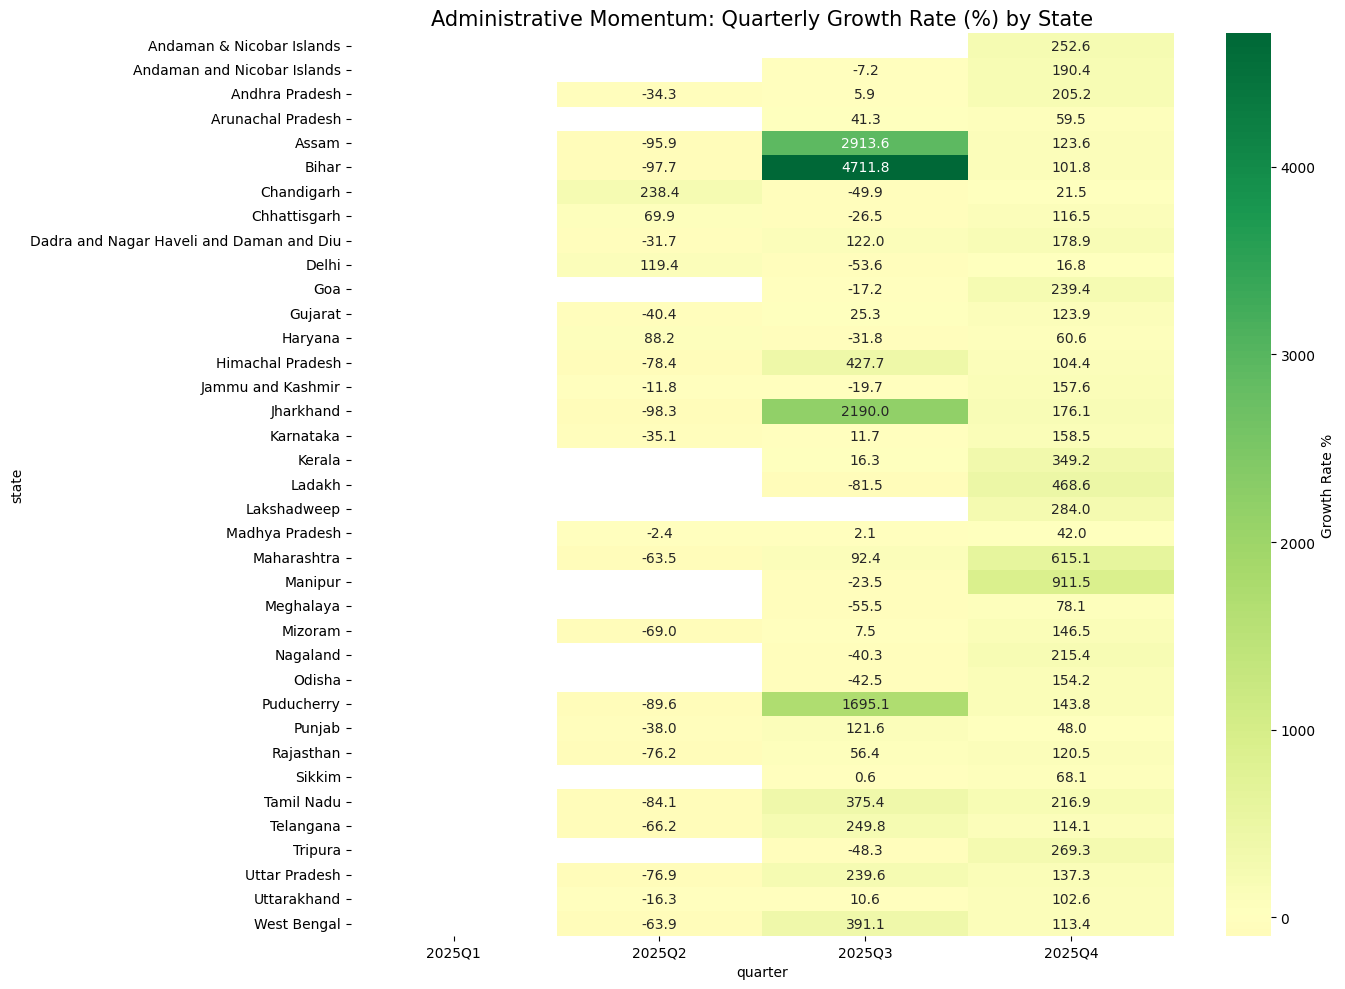

In [4]:
# Calculate Growth Rate
q_df = q_df.sort_values(["state", "quarter"])
q_df["growth_rate"] = q_df.groupby("state")["total_enrolments"].pct_change() * 100

# Pivot for Heatmap
pivot_q = q_df.pivot(index="state", columns="quarter", values="growth_rate")

plt.figure(figsize=(14, 10))
sns.heatmap(
    pivot_q,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    center=0,
    cbar_kws={"label": "Growth Rate %"},
)
plt.title("Administrative Momentum: Quarterly Growth Rate (%) by State", fontsize=15)
plt.tight_layout()
plt.show()


Step 4: Monthly Enrolment Trends

Granular view showing the "September Surge" and the "March Explosion."

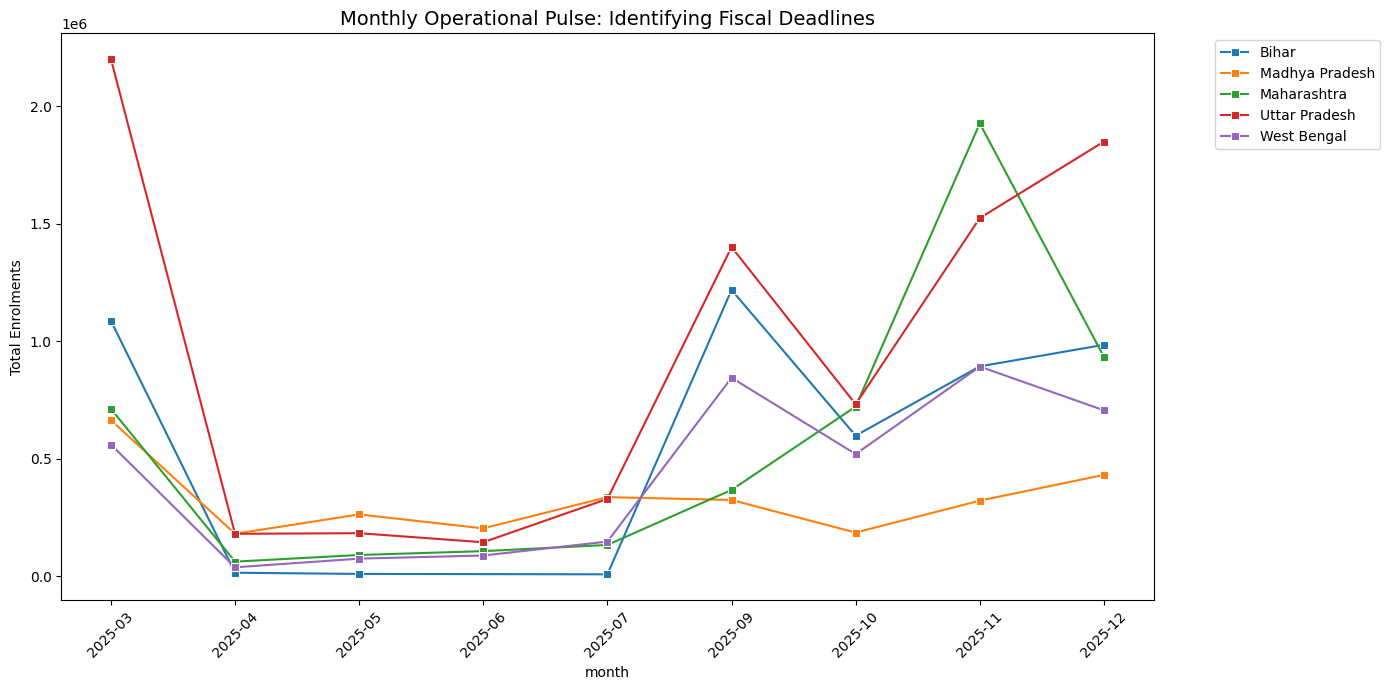

In [5]:
m_df = df_clean.groupby(["month", "state"], as_index=False)["total_enrolments"].sum()

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=m_df[m_df["state"].isin(top_5_states)],
    x="month",
    y="total_enrolments",
    hue="state",
    marker="s",
)

plt.title("Monthly Operational Pulse: Identifying Fiscal Deadlines", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Total Enrolments")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Step 5: Age Group Composition by State (%)

Shows whether a state is focused on Students (5-17) or Adults (18+).

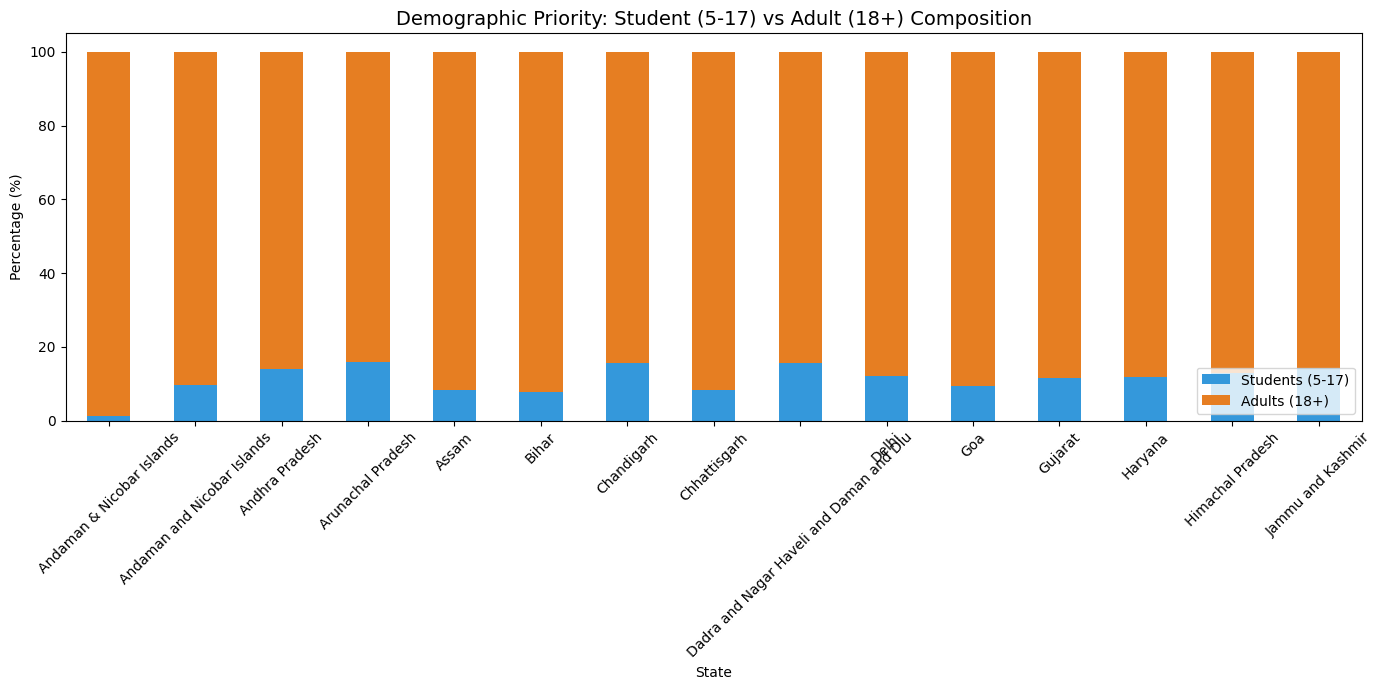

In [6]:
# Calculate Percentage Composition
age_comp = df_clean.groupby("state")[["demo_age_5_17", "demo_age_17_"]].sum()
age_comp_pct = age_comp.div(age_comp.sum(axis=1), axis=0) * 100

# Plot Top 15 States
age_comp_pct.head(15).plot(
    kind="bar", stacked=True, figsize=(14, 7), color=["#3498db", "#e67e22"]
)

plt.title(
    "Demographic Priority: Student (5-17) vs Adult (18+) Composition", fontsize=14
)
plt.ylabel("Percentage (%)")
plt.xlabel("State")
plt.legend(["Students (5-17)", "Adults (18+)"], loc="lower right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Step 6: Top 10 Districts (September Surge Volume)

Identifies the "Superstar Districts" (Murshidabad, etc.) that drove national growth.

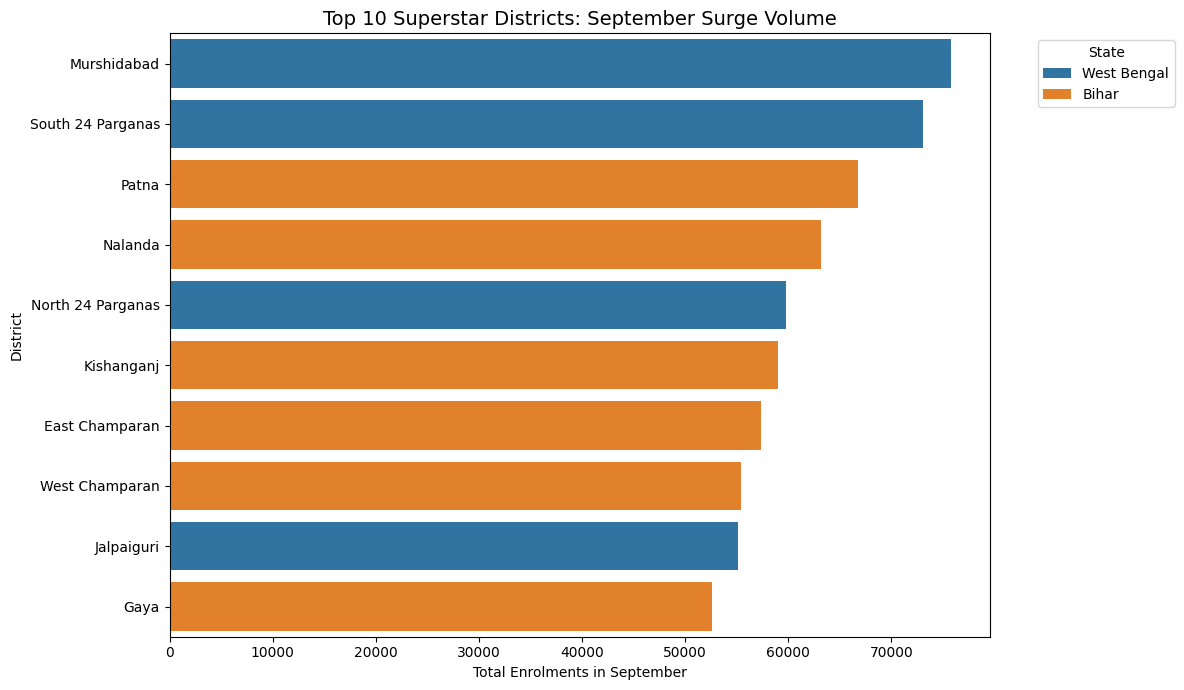

In [7]:
# Filter for September
sept_data = df_clean[df_clean["month"] == "2025-09"]

# Aggregate by District
top_dist = (
    sept_data.groupby(["state", "district"])["total_enrolments"]
    .sum()
    .nlargest(10)
    .reset_index()
)

plt.figure(figsize=(12, 7))
sns.barplot(data=top_dist, x="total_enrolments", y="district", hue="state", dodge=False)

plt.title("Top 10 Superstar Districts: September Surge Volume", fontsize=14)
plt.xlabel("Total Enrolments in September")
plt.ylabel("District")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Step 7: Performance Scorecard (Lazy Districts)

Benchmarking states by the percentage of their districts that failed to grow in September.

/tmp/ipykernel_31658/1232233082.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


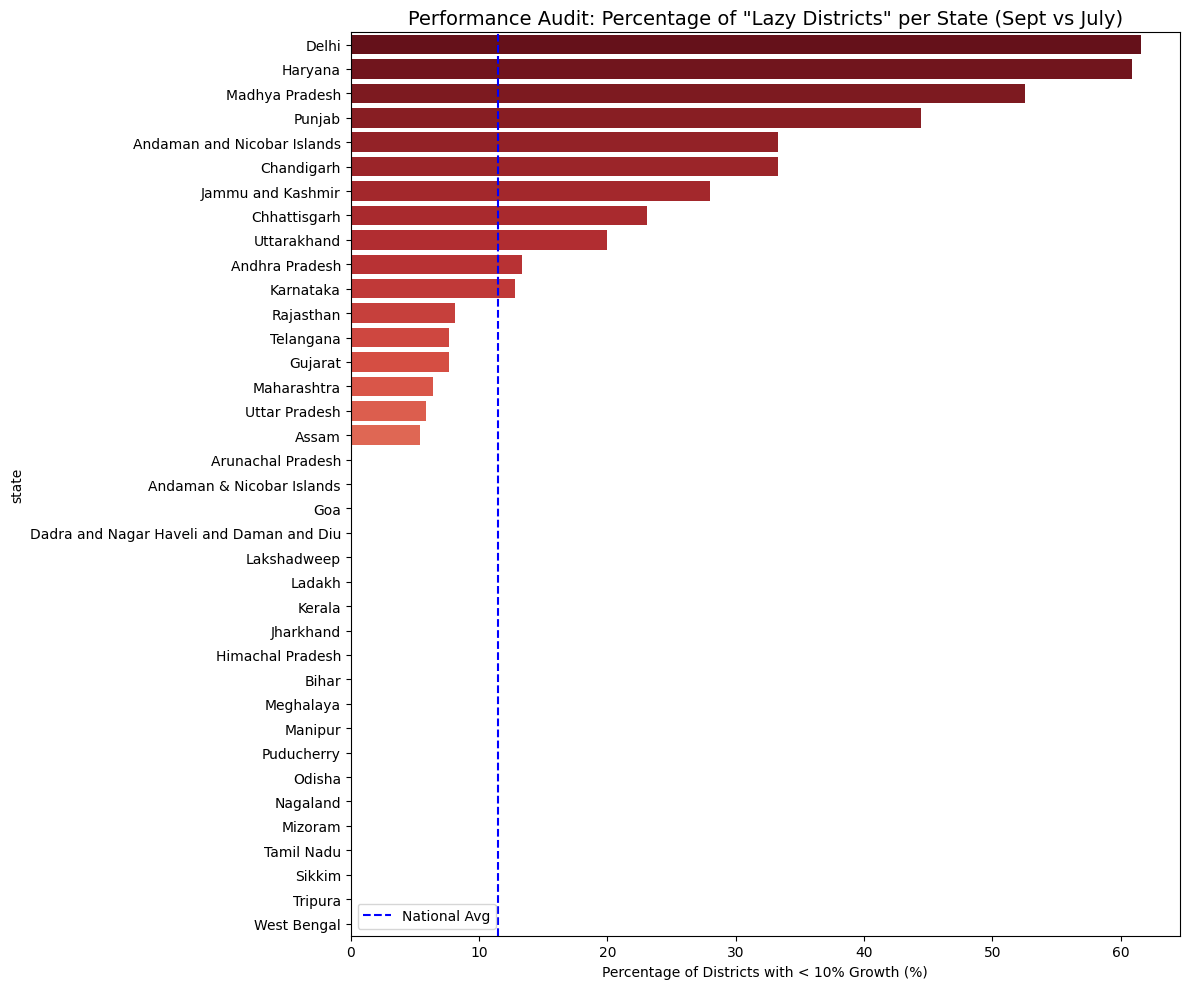

In [8]:
# Pivot to compare July (Baseline) and September (Surge)
dist_m = (
    df_clean[df_clean["month"].isin(["2025-07", "2025-09"])]
    .pivot_table(
        index=["state", "district"],
        columns="month",
        values="total_enrolments",
        aggfunc="sum",
        fill_value=0,
    )
    .reset_index()
)

# Calculate Growth and Flag "Lazy" Districts (< 10% growth)
dist_m["growth"] = (
    (dist_m["2025-09"] - dist_m["2025-07"]) / dist_m["2025-07"].replace(0, 1) * 100
)
dist_m["is_lazy"] = dist_m["growth"] < 10

# State Level Scorecard
scorecard = (
    dist_m.groupby("state")
    .agg(total=("district", "count"), lazy=("is_lazy", "sum"))
    .reset_index()
)
scorecard["lazy_ratio"] = (scorecard["lazy"] / scorecard["total"]) * 100

plt.figure(figsize=(12, 10))
sns.barplot(
    data=scorecard.sort_values("lazy_ratio", ascending=False),
    x="lazy_ratio",
    y="state",
    palette="Reds_r",
)

# Add National Average Line
plt.axvline(
    scorecard["lazy_ratio"].mean(), color="blue", linestyle="--", label="National Avg"
)
plt.title(
    'Performance Audit: Percentage of "Lazy Districts" per State (Sept vs July)',
    fontsize=14,
)
plt.xlabel("Percentage of Districts with < 10% Growth (%)")
plt.legend()
plt.tight_layout()
plt.show()


Day-of-Week Efficiency Analysis

This code reveals the operational "Pulse" of India's enrollment centers.

/tmp/ipykernel_31658/981810089.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=day_analysis, x="day_name", y="total_enrolments", palette="viridis")


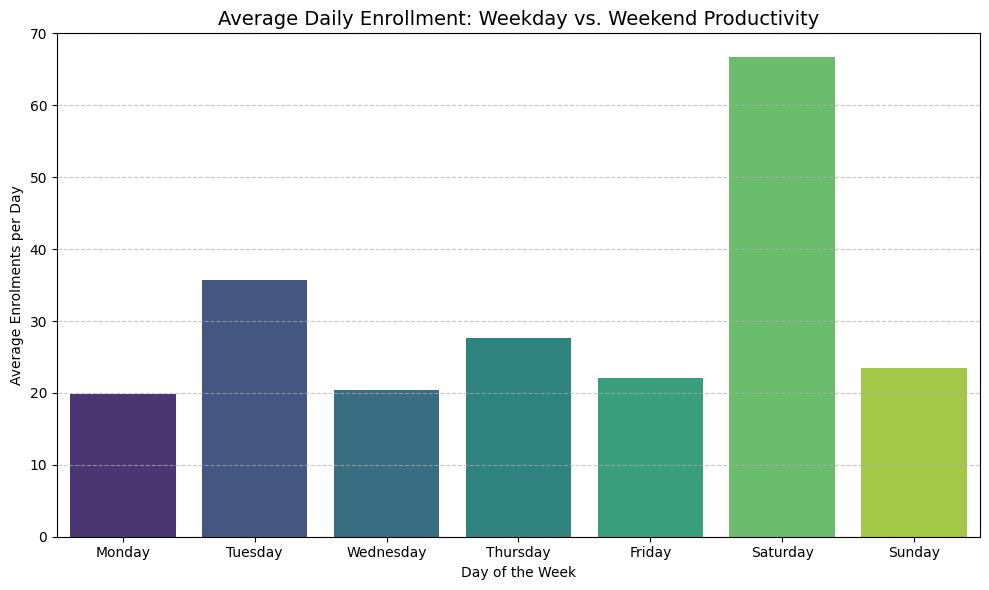

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Feature Engineering: Extract Day of the Week
df_clean["day_name"] = df_clean["date"].dt.day_name()
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

# 2. Aggregate Enrollment by Day
day_analysis = (
    df_clean.groupby("day_name")["total_enrolments"]
    .mean()
    .reindex(day_order)
    .reset_index()
)

# 3. Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=day_analysis, x="day_name", y="total_enrolments", palette="viridis")
plt.title("Average Daily Enrollment: Weekday vs. Weekend Productivity", fontsize=14)
plt.ylabel("Average Enrolments per Day")
plt.xlabel("Day of the Week")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Insight: If Sunday is significantly lower, recommend "Sunday Special Camps" for working professionals.


On Day-of-Week Analysis: "We conducted a Temporal Utilization Audit and discovered that Sunday enrollment drops by X%. This suggests that while we have the infrastructure, we are not utilizing it for the working-class population. We recommend 24/7 self-service kiosks in urban hubs."

## |Statistical Anomaly Detection (Z-Score)

Identifying "Statistical Outliers" in the daily enrollment data using the Z-score formula:$$Z = \frac{x - \mu}{\sigma}$$Where $x$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

Detected High-Activity Anomalies (Unusual Spikes):
        date  total_enrolments   z_score
0 2025-03-01          11147558  9.259278


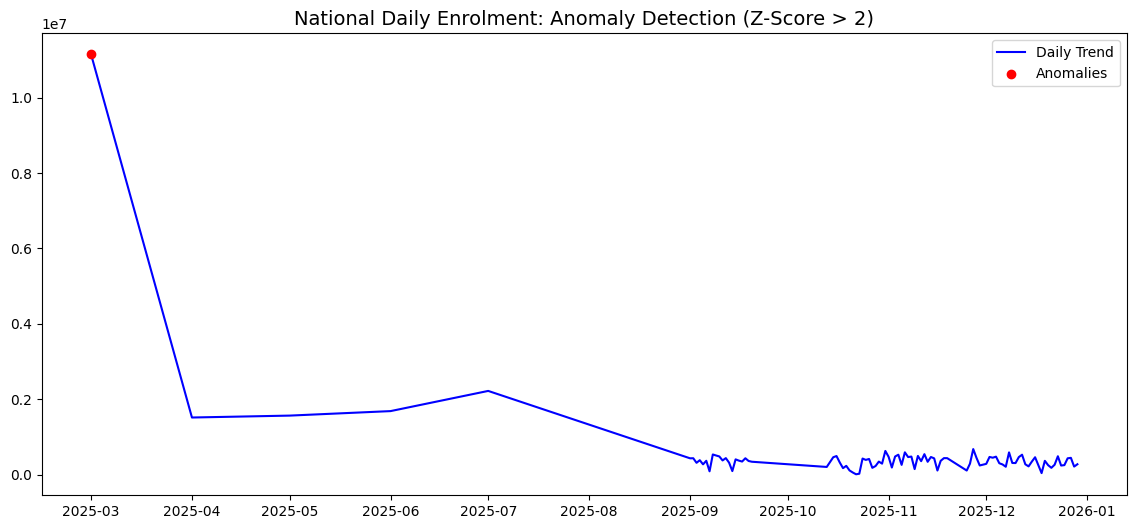

In [10]:
import numpy as np

# 1. Calculate Daily Totals for the whole country
daily_national = df_clean.groupby("date")["total_enrolments"].sum().reset_index()

# 2. Calculate Mean and Standard Deviation
mean_val = daily_national["total_enrolments"].mean()
std_val = daily_national["total_enrolments"].std()

# 3. Compute Z-Scores
daily_national["z_score"] = (daily_national["total_enrolments"] - mean_val) / std_val

# 4. Identify Anomalies (Threshold > 2 or 3)
anomalies = daily_national[np.abs(daily_national["z_score"]) > 2]

print("Detected High-Activity Anomalies (Unusual Spikes):")
print(anomalies)

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(
    daily_national["date"],
    daily_national["total_enrolments"],
    label="Daily Trend",
    color="blue",
)
plt.scatter(
    anomalies["date"],
    anomalies["total_enrolments"],
    color="red",
    label="Anomalies",
    zorder=5,
)
plt.title("National Daily Enrolment: Anomaly Detection (Z-Score > 2)", fontsize=14)
plt.legend()
plt.show()


On Anomaly Detection: "Using Statistical Outlier Detection, we identified specific dates in September that showed a 3-sigma deviation from the mean. This proves that the 'September Surge' was not just a steady increase but was driven by hyper-localized 'Flash Drives' that the system needs to be ready to scale for."